# Classification single feature

Classification using "raw" python or libraries.
The classification is first on a single boundary (single class) defined by a continuous function

In [42]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
from sklearn.linear_model import LogisticRegression as SkLinReg
from sklearn.preprocessing import OneHotEncoder as SkOneHotEncoder
import scikitplot as skplt
import scipy as sy
import pandas

## Model

We want to measure or predict a value y to be above a threshold. E.g.: y is a temperature.

We know a feature x, y is related to x through a quadratic function we do not a priori know and some unknown

This unknown is modeled by a Gaussian noise

In [2]:
#
xMin = 0
xMax = 1
b = 0.2
std = 0.2
# Threshold from 0 to 1
threshold = 1
# Single feature, Gaussian noise
def generateBatch(N):
    x = random.uniform(xMin, xMax, N)
    # 4th degree relation between y and x
    yClean = 2*(x**4 + (x-0.3)**3 + b)
    labels = yClean + random.normal(0, std, N) > threshold
    return (x, yClean, labels)

The valus of X are uniformly distributed and independent

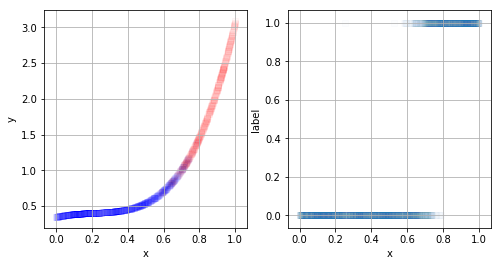

In [3]:
N = 2000
# x has 2 dim in R, y has 1 dim in B (labels)
xTrain, yCleanTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(xTrain, yCleanTrain, c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
#cb = plt.colorbar()
#loc = np.arange(0,1,1/float(len(colors)))
#cb.set_ticks(loc)
#cb.set_ticklabels([0,1])
plt.subplot(1,2,2)
plt.scatter(xTrain, labelTrain, marker=',', alpha=0.01)
plt.xlabel('x')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.3125


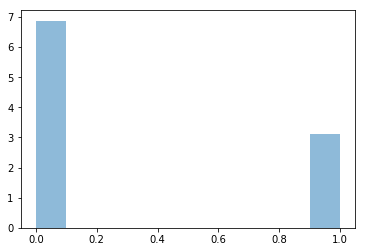

In [4]:
count, bins, ignored = plt.hist(labelTrain, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

In [5]:
xTest, yTest, labelTest = generateBatch(N)

In [6]:
def logistic(X):
    return (1+(np.exp(-(X))))**-1

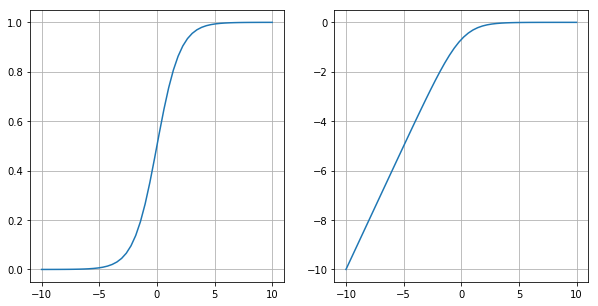

In [7]:
xx = np.linspace(-10, 10)
xlogistic = logistic(xx)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(xx, xlogistic)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(xx, np.log(xlogistic))
plt.grid()

# Logistic regression

\begin{align}
y \in \left\{ 0, 1 \right\}
\end{align}

\begin{align}
p(Y=1 \mid x) & = \frac{1}{1+e^{-f(x)}} \\
f(x) & = w_0 + w_1 x 
\end{align}

We are looking for the value of w that maximize the likelyhood:
\begin{align}
\hat{w} & = \max_{w}{\prod_{i=0}^N{p(y_i \mid  x_i, w)}} \\
& = \max_{w}{\sum_{i=0}^N{log \bigl(p(y_i \mid x_i, w)\bigr)} } \\
& = \max_{w}{\sum_{i=0}^N{log \biggl(\bigl(\frac{1}{1+e^{-f(x)}}\bigr)^{y_i}\bigl(1-\frac{1}{1+e^{-f(x)}}\bigr)^{1-y_i}\biggr)} } \\
& = \max_{w}{\sum_{i=0}^N{log \biggl(y_i * \bigl(\frac{1}{1+e^{-f(x)}}\bigr) + \bigl(1-y_i\bigr) * \bigl(1-\frac{1}{1+e^{-f(x)}}\bigr) \biggr)} } \\
\end{align}

Using the fact that $y_i$ is either 0 or 1

Reference:
- https://en.wikipedia.org/wiki/Logistic_regression


## Fitting of $w_0$ and then $w_1$


Suboptimal fitting:
- Taking some assumption on $w_1$ to fit $w_0$ 
- and then fitting $w_1$ with the $\hat{w_0}$ estimate

$\hat{w_0}$ = -1.3265306122448979


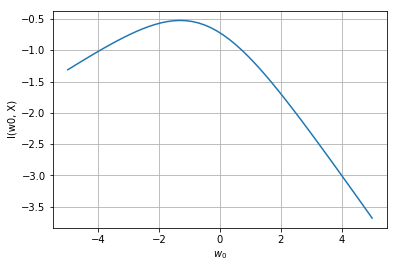

In [8]:
w0 = np.linspace(-5, 5)
w1 = 1
px = np.zeros(len(w0))
for i in range(len(w0)):
    fx = logistic(w0[i] + w1*xTrain)
    px[i] = 1/N * np.sum(np.log(labelTrain*fx + (1-labelTrain)*(1-fx)))
plt.plot(w0, px);
plt.xlabel('$w_0$')
plt.ylabel('l(w0, X)')
plt.grid()
w0Hat = w0[np.argmax(px)]
print('$\hat{w_0}$ =', w0Hat) 

2.0408163265306136

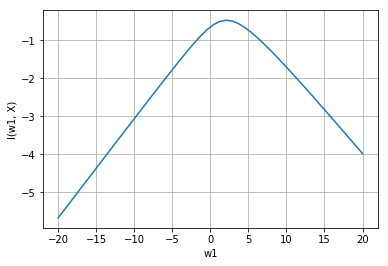

In [9]:
w1 = np.linspace(-20, 20)
px = np.zeros(len(w1))
for i in range(len(w1)):
    fx = logistic(w0Hat + w1[i]*xTrain)
    px[i] = 1/N * np.sum(np.log(labelTrain*fx + (1-labelTrain)*(1-fx)))
plt.plot(w1, px);
plt.xlabel('w1')
plt.ylabel('l(w1, X)')
plt.grid()
w1Hat = w1[np.argmax(px)]
w1Hat

In [10]:
pXTest0 = logistic(w0Hat + w1Hat * xTest)
labelEst0 = pXTest0 > 0.5

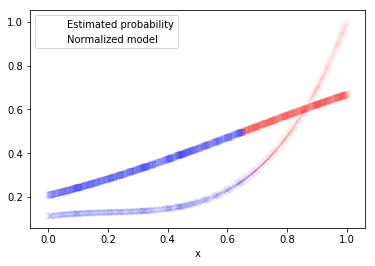

In [11]:
plt.scatter(xTest, pXTest0, c=labelEst0, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.01);
plt.scatter(xTest, yTest/np.max(yTest), c = labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.01);
plt.xlabel('x')
plt.legend(('Estimated probability', 'Normalized model'));

Bernouilli parameter = 0.3565


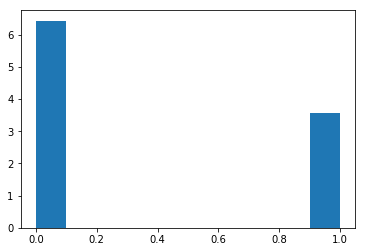

In [25]:
plt.hist(labelEst0, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst0))

In [13]:
accuracy0 = np.sum(labelTest == labelEst0)/N
print('Accuracy =', accuracy0)

Accuracy = 0.9385


Precision: $p(y = 1 \mid \hat{y} = 1)$

In [14]:
print('Precision =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelEst0))

Precision = 0.8583450210378681


Recall: $p(\hat{y} = 1 \mid y = 1)$

In [26]:
print('Recall =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelTest))

Recall = 0.9652996845425867


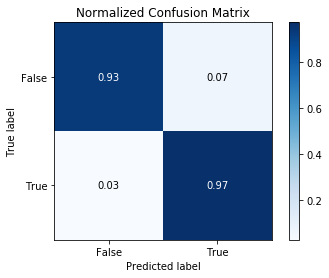

In [16]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst0, normalize=True);

In [17]:
print(skMetrics.classification_report(labelTest, labelEst0))

              precision    recall  f1-score   support

       False       0.98      0.93      0.95      1366
        True       0.86      0.97      0.91       634

    accuracy                           0.94      2000
   macro avg       0.92      0.95      0.93      2000
weighted avg       0.94      0.94      0.94      2000



# SciKit Learn

References:
- SciKit documentation
- https://www.geeksforgeeks.org/ml-logistic-regression-using-python/

In [18]:
model1 = SkLinReg(solver='lbfgs')
model1.fit(xTrain.reshape(-1,1), labelTrain)
model1.coef_

array([[13.33918729]])

In [19]:
labelEst1 = model1.predict(xTest.reshape(-1,1))
print('Accuracy =',model1.score(xTest.reshape(-1,1), labelTest))

Accuracy = 0.9555


0.3135

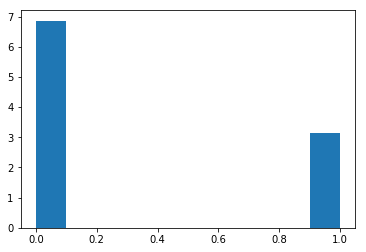

In [20]:
plt.hist(labelEst1, 10, density=True)
np.mean(labelEst1)

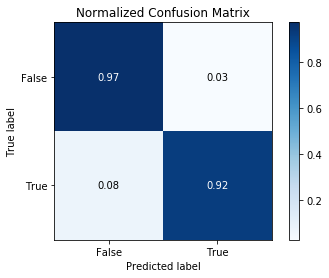

In [21]:
#skMetrics.confusion_matrix(labelTest, labelEst1)
skplt.metrics.plot_confusion_matrix(labelTest, labelEst1, normalize=True);

In [22]:
print(skMetrics.classification_report(labelTest, labelEst1))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1366
        True       0.93      0.92      0.93       634

    accuracy                           0.96      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.96      0.96      0.96      2000



References :
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.get_params

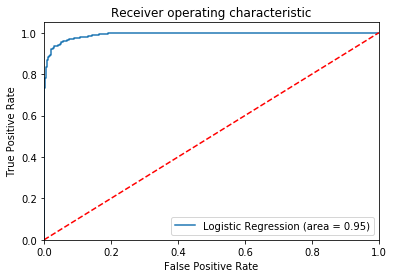

In [23]:
logit_roc_auc = skMetrics.roc_auc_score(labelTest, labelEst1)
fpr, tpr, thresholds = skMetrics.roc_curve(labelTest, model1.predict_proba(xTest.reshape(-1,1))[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

# Using TensorFlow

Reference:
- https://www.geeksforgeeks.org/ml-logistic-regression-using-tensorflow/

In [29]:
import tensorflow as tf

In [54]:
# Creating the One Hot Encoder 
#oneHot = SkOneHotEncoder(categories='auto') 

# Encoding y_orig 
#oneHot.fit(labelTrain.reshape(-1,1)) 
#labelTrain1H = oneHot.transform(labelTrain.reshape(-1,1)).toarray() 
#labelTrain1H.shape
labelTrain1H = np.multiply(labelTrain, 1)

In [57]:
# Batch size, learning rate, epochs
Nbatch = 100
alpha = 0.01
Nepoch = 500
# x and y are placeholders for our training data
X = tf.placeholder("float")
Y = tf.placeholder("float")
# Initial weights
Wtf = tf.Variable([1.0, 1.0], name="w")
# Our model of y = sigmoid(a*x + b)
Y_model = tf.sigmoid(tf.multiply(X, Wtf[1]) + Wtf[0])
# Sigmoid Cross Entropy Cost Function 
cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_model, labels = Y) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer(learning_rate = alpha).minimize(cost) 

# Global Variables Initializer 
init = tf.global_variables_initializer() 

In [63]:
# Starting the Tensorflow Session 
with tf.Session() as sess: 

    # Initializing the Variables 
    sess.run(init) 
    
    # Lists for storing the changing Cost and Accuracy in every Epoch 
    cost_history, accuracy_history = [], [] 

    # Iterating through all the epochs 
    for epoch in range(Nepoch): 
        cost_per_epoch = 0

        # Running the Optimizer 
        sess.run(optimizer, feed_dict = {X : xTrain, Y : labelTrain1H}) 

        # Calculating cost on current Epoch 
        c = sess.run(cost, feed_dict = {X : xTrain, Y : labelTrain1H}) 

        # Calculating accuracy on current Epoch 
        correct_prediction = tf.equal(tf.argmax(Y_model, 1), tf.argmax(labelTrain1H, 1)) 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

        # Storing Cost and Accuracy to the history 
        cost_history.append(np.sum(np.sum(c))) 
        accuracy_history.append(accuracy.eval({X : xTrain.reshape(-1,1), Y : labelTrain1H.reshape(-1,1)}) * 100) 

        # Displaying result on current Epoch 
        if epoch % 100 == 0 and epoch != 0: 
            print("Epoch " + str(epoch) + " Cost: " + str(cost_history[-1])) 
            
    Weight = sess.run(W) # Optimized Weight 
    Bias = sess.run(b) # Optimized Bias 

    # Final Accuracy 
    correct_prediction = tf.equal(tf.argmax(Y_hat, 1), 
                                    tf.argmax(Y, 1)) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                            tf.float32)) 
    print("\nAccuracy:", accuracy_history[-1], "%") 

InvalidArgumentError: Expected dimension in the range [-1, 1), but got 1
	 [[node ArgMax_15 (defined at <ipython-input-63-7592eebb0d29>:21) ]]

Original stack trace for 'ArgMax_15':
  File "/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-7592eebb0d29>", line 21, in <module>
    correct_prediction = tf.equal(tf.argmax(Y_model, 1), tf.argmax(labelTrain1H, 1))
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 138, in argmax
    return argmax_v2(input, axis, output_type, name)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 175, in argmax_v2
    return gen_math_ops.arg_max(input, axis, name=name, output_type=output_type)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 948, in arg_max
    name=name)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
